In [1]:
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [2]:
!pip install imutils
!pip install image-classifiers==1.0.0b1

In [3]:
import tensorflow as tf
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import VGG16, DenseNet169
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
#from classification_models.tfkeras import Classifiers
from datetime import datetime
%load_ext tensorboard

In [4]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('acc') >= 0.96):   
            print("Reached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [5]:
EPOCHS =50
INIT_LR = 3e-3
BS =32
default_image_size = tuple((224, 224))
image_size = 0
width=224
height=224
depth=3
train_dir=r"C:\Users\Glau\Desktop\Burn_Aug"
#valid_dir=r"C:\Users\Glau\Desktop\DP\Pediastrum_cnn\Test"
train_folder=listdir(train_dir)
#valid_folder=listdir(valid_dir)

In [6]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [7]:
callbacks = MyCustomCallback()

In [8]:
train_image_list, train_image_label=[],[]
for disease_folder in train_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{train_dir}/{disease_folder}")
    #print(disease_img_folder)
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]:    
        image_directory = f"{train_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpeg") == True or image_directory.endswith(".jpg") == True or  image_directory.endswith(".png") == True:
            train_image_list.append(convert_image_to_array(image_directory))
            train_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing dd ...
processing ft ...
processing sd ...
[INFO] Image loading completed


In [9]:
print(len(train_image_label))

6000


In [10]:
label_binarizer = LabelBinarizer()
bin_train_image_labels = label_binarizer.fit_transform(train_image_label)
#bin_valid_image_labels = label_binarizer.fit_transform(valid_image_label)
pickle.dump(label_binarizer,open('Label_Instance_burn_label4.pk', 'wb'))
n_classes = len(label_binarizer.classes_)

In [11]:
print(len(bin_train_image_labels))

6000


In [12]:
np_train_image_list = np.array(train_image_list, dtype=np.float32) / 255.0

In [13]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [14]:
# coding: utf8
from tensorflow.keras import layers
from tensorflow.keras import models


#
# image dimensions
#

img_height = 224
img_width = 224
img_channels = 3

#
# network params
#

cardinality = 32


def residual_network(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:

        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):#3
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 64, 128, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):#4
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 128, 256, _strides=strides)

    # conv4
    for i in range(6):#6
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv5
    for i in range(3):#3
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 512, 2048, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(3,activation='softmax')(x)

    return x


image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = residual_network(image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 256 19456       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 256 1024        conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 112, 112, 256 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

print("[INFO] training network...")

[INFO] training network...


In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,classification_report 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer

In [22]:
conf_matrix_list_of_arrays = []
#loss_per_fold = []
seed = 13   # for reproducibility you can change it. 
np.random.seed(seed)
roundlabel=[]
test=[]
idtest=[]
x_validate=[]
kfold = KFold(5, True, seed)
for train_idx, val_idx in kfold.split(np_train_image_list, y=bin_train_image_labels):
    #print('train: %s, val: %s' % (train_idx, val_idx))
    x_train, x_val = np_train_image_list[train_idx], np_train_image_list[val_idx]
    y_train, y_val= bin_train_image_labels[train_idx], bin_train_image_labels[val_idx]
    history=model.fit(x_train, y_train,
                  validation_data=(x_val, y_val),
                  batch_size=BS,
                  epochs=EPOCHS, verbose=1        
                  )
    ycalculated = model.predict(x_val)
    yhat_classes =np.argmax(ycalculated,axis=1)
    rounded_labels=np.argmax(y_val,axis=1)                           
    conf_matrix = confusion_matrix(rounded_labels,yhat_classes)
    conf_matrix_list_of_arrays .append(conf_matrix)
    roundlabel.append(rounded_labels)
    test.append(yhat_classes)
    idtest.append(val_idx)
    
print('Score per fold')
for i in range(0, len(conf_matrix_list_of_arrays)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1}  - Accuracy: {conf_matrix_list_of_arrays[i]}%')   

Train on 4800 samples, validate on 1200 samples
Epoch 1/5
4800/4800 [==============================] - 57s 12ms/sample - loss: 0.0252 - accuracy: 0.9919 - val_loss: 0.2301 - val_accuracy: 0.9317
Epoch 2/5
4800/4800 [==============================] - 58s 12ms/sample - loss: 0.0141 - accuracy: 0.9962 - val_loss: 0.7927 - val_accuracy: 0.8483
Epoch 3/5
4800/4800 [==============================] - 58s 12ms/sample - loss: 0.0427 - accuracy: 0.9865 - val_loss: 0.0105 - val_accuracy: 0.9975
Epoch 4/5
4800/4800 [==============================] - 59s 12ms/sample - loss: 0.0142 - accuracy: 0.9950 - val_loss: 0.0439 - val_accuracy: 0.9808
Epoch 5/5
4800/4800 [==============================] - 59s 12ms/sample - loss: 0.0208 - accuracy: 0.9923 - val_loss: 3.8797 - val_accuracy: 0.6508
Train on 4800 samples, validate on 1200 samples
Epoch 1/5
4800/4800 [==============================] - 60s 12ms/sample - loss: 0.0328 - accuracy: 0.9875 - val_loss: 0.3517 - val_accuracy: 0.8925
Epoch 2/5
4800/4800 [=

In [45]:
#c=0
#for i in range(len(rounded_labels)):
    #if(rounded_labels[i]==0):
       # c=c+1
#print(c)
#print(len(yhat_classes))
print(x_val)
    

[[[[0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   ...
   [0.49411765 0.5058824  0.49803922]
   [0.49411765 0.5058824  0.49803922]
   [0.49411765 0.5058824  0.49803922]]

  [[0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   ...
   [0.49411765 0.5058824  0.49803922]
   [0.49411765 0.5058824  0.49803922]
   [0.49411765 0.5058824  0.49803922]]

  [[0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   ...
   [0.49411765 0.5058824  0.49803922]
   [0.49411765 0.5058824  0.49803922]
   [0.49411765 0.5058824  0.49803922]]

  ...

  [[0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   ...
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]]

  [[0.5019608  0.5019608  0.5019608 ]
   [0.5

In [28]:
for i in range(len(roundlabel[1])):
    print(roundlabel[1][i])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [19]:
print(test[0])

[2 1 0 ... 2 2 2]


In [29]:
for i in range(len(test[3])):
    print(test[3][i])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1


In [26]:
c=0
for i in range(len(test[1])):
    if (test[1][i] == 0):
        print(i,end="   ")
        print(test[1][i])
        c+=1
print(c)

0   0
1   0
2   0
3   0
4   0
5   0
7   0
10   0
11   0
13   0
14   0
15   0
17   0
18   0
20   0
21   0
23   0
24   0
25   0
27   0
29   0
30   0
31   0
32   0
34   0
39   0
40   0
41   0
42   0
43   0
47   0
48   0
49   0
50   0
53   0
54   0
55   0
56   0
57   0
59   0
60   0
61   0
62   0
63   0
64   0
66   0
67   0
68   0
69   0
71   0
72   0
73   0
74   0
75   0
76   0
79   0
80   0
81   0
83   0
84   0
86   0
87   0
88   0
89   0
91   0
94   0
95   0
97   0
98   0
99   0
100   0
101   0
102   0
103   0
105   0
106   0
109   0
110   0
111   0
113   0
114   0
115   0
116   0
117   0
118   0
120   0
121   0
123   0
125   0
126   0
127   0
128   0
129   0
130   0
132   0
133   0
134   0
135   0
136   0
138   0
139   0
140   0
141   0
142   0
143   0
145   0
146   0
147   0
149   0
150   0
151   0
153   0
156   0
157   0
158   0
159   0
161   0
164   0
165   0
166   0
167   0
169   0
170   0
173   0
174   0
176   0
178   0
180   0
183   0
184   0
185   0
188   0
189   0
192   0
194  

In [30]:
for i in range(len(idtest[3])):
    print(idtest[3][i])


2
10
20
26
31
32
37
41
43
45
51
54
59
62
69
82
84
92
94
95
97
103
107
108
109
110
111
112
116
120
126
130
132
133
136
141
158
162
173
174
188
193
196
210
212
222
228
235
238
241
253
254
255
259
260
271
274
275
276
284
286
289
293
297
298
306
321
322
323
335
337
340
341
347
361
362
370
376
377
379
396
401
417
424
434
437
443
446
447
450
461
463
464
465
466
468
469
473
475
478
480
495
504
505
508
511
512
539
541
544
550
557
558
563
565
577
579
587
592
597
600
609
611
612
615
618
619
623
626
630
635
636
638
653
661
670
676
680
693
698
702
712
714
716
719
720
724
735
749
755
761
762
767
768
770
771
779
785
787
789
791
802
804
806
816
817
826
829
836
846
848
849
856
870
872
881
882
883
885
889
897
900
902
907
913
940
942
947
952
957
958
962
964
965
967
973
974
976
980
988
997
998
1004
1011
1020
1026
1028
1031
1042
1053
1059
1067
1068
1071
1087
1091
1094
1097
1100
1110
1117
1125
1130
1136
1137
1138
1147
1148
1154
1156
1157
1158
1168
1172
1174
1177
1178
1186
1200
1204
1205
1207
1208
1209
1213

In [24]:
cm=conf_matrix_list_of_arrays[0]
print(cm)

[[378   0  15]
 [293  78  45]
 [203   0 188]]


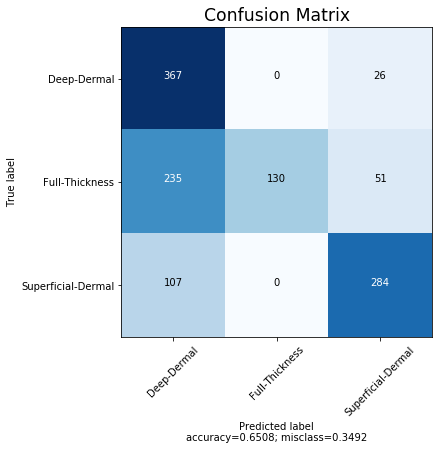

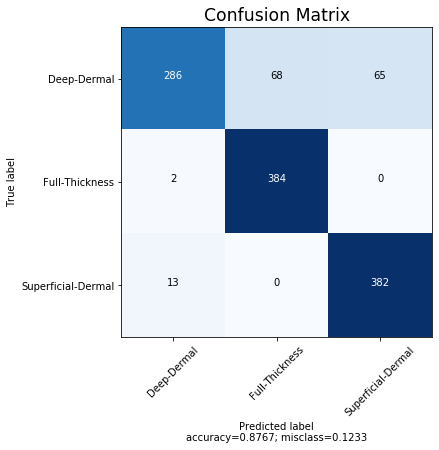

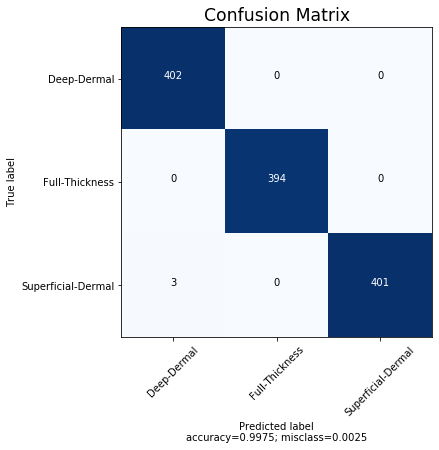

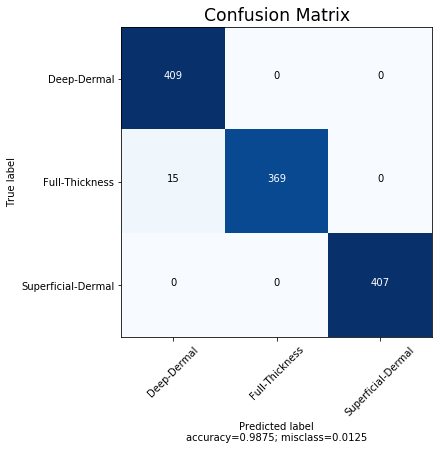

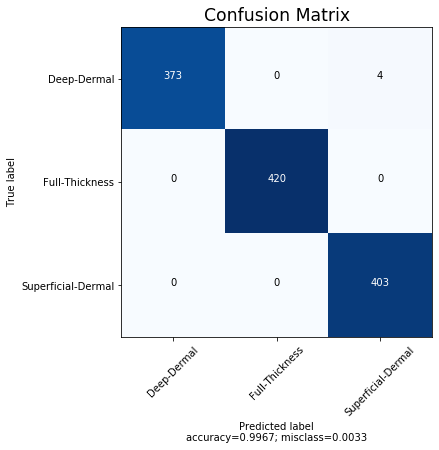

In [23]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
for i in range(5):
    plot_confusion_matrix(conf_matrix_list_of_arrays[i], 
                      normalize = False,
                      target_names = ['Deep-Dermal', 'Full-Thickness', 'Superficial-Dermal'],
                      title        = "Confusion Matrix")

In [27]:
from sklearn.metrics import accuracy_score,classification_report 
target_names = ['Deep-Dermal', 'Full-Thickness', 'Superficial-Dermal']
print(classification_report(rounded_labels, yhat_classes, target_names=target_names))

                    precision    recall  f1-score   support

       Deep-Dermal       1.00      1.00      1.00       377
    Full-Thickness       1.00      1.00      1.00       420
Superficial-Dermal       1.00      1.00      1.00       403

          accuracy                           1.00      1200
         macro avg       1.00      1.00      1.00      1200
      weighted avg       1.00      1.00      1.00      1200



In [31]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
#cm = confusion_matrix(testY, np.argmax(predY, axis = -1))
total = sum(sum(conf_matrix_list_of_arrays[3]))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
#precision=
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)

print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[378   0  15]
 [293  78  45]
 [203   0 188]]
sensitivity: 1.0000
specificity: 0.2102


In [32]:
class_to_label_map={0:'Deep-Dermal', 1:'Full-Thickness', 2:'Superficial-Dermal' }

C:\Users\Glau\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


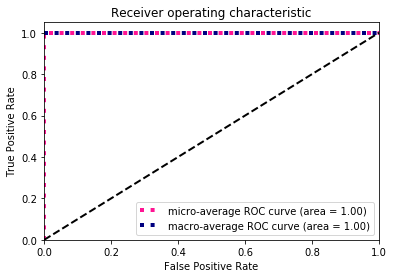

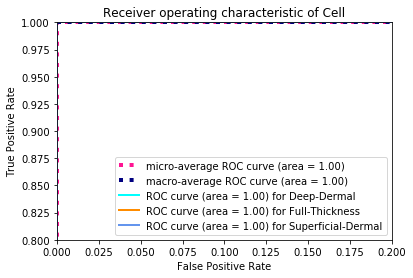

In [33]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

n_classes =3

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
lb = LabelBinarizer()
lb.fit(rounded_labels)
y_test= lb.transform(rounded_labels)
snn_pred = lb.transform(yhat_classes)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], snn_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), snn_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes-97), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw,color='white')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Cell')
plt.legend(loc="lower right")
plt.show()


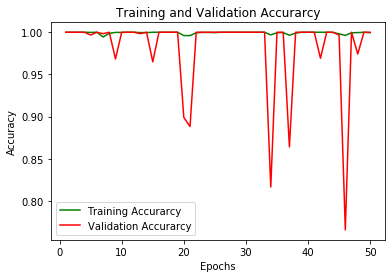

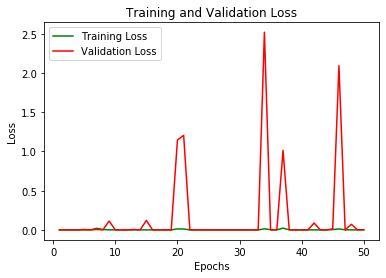

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training Accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation Accurarcy')
plt.title('Training and Validation Accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()